# Analysis of the electricity price data

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilities import create_timestamps

plt.style.use("seaborn-v0_8-colorblind")

data_dir = os.path.join(os.path.dirname(os.getcwd()), "data", "processed")

# Load BMRS data (generation, demand, prices)
df_bmrs = pd.read_csv(
    os.path.join(data_dir, "bmrs_data.csv"),
    parse_dates=["SETTLEMENT_DATE"],
)

# Keep only the electricity prices and settlement dates/periods
df_price = df_bmrs[["SETTLEMENT_DATE", "SETTLEMENT_PERIOD", "ELECTRICITY_PRICE"]]

# Sort by date and period
df_price = df_price.sort_values(["SETTLEMENT_DATE", "SETTLEMENT_PERIOD"])

# Create timestamps
df_price["TIMESTAMP"] = create_timestamps(
    df_price, "SETTLEMENT_DATE", "SETTLEMENT_PERIOD"
)

# Set date and period as index
df_price.set_index(["SETTLEMENT_DATE", "SETTLEMENT_PERIOD"], inplace=True)

df_price.head()

ELECTRICITY_PRICE                 TIMESTAMP
SETTLEMENT_DATE SETTLEMENT_PERIOD                                             
2021-01-01      1                              68.54 2021-01-01 00:00:00+00:00
                2                              69.82 2021-01-01 00:30:00+00:00
                3                              67.42 2021-01-01 01:00:00+00:00
                4                              65.45 2021-01-01 01:30:00+00:00
                5                              59.44 2021-01-01 02:00:00+00:00

## 1. Trends

Plot daily mean electricity prices:

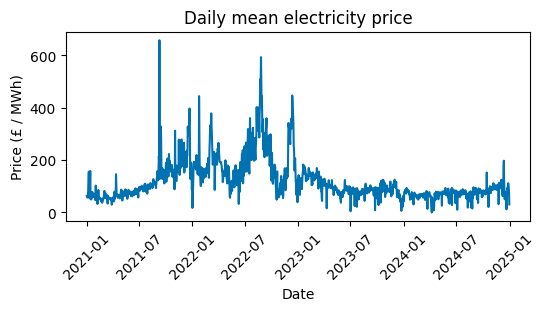

In [2]:
daily_price = df_price.groupby("SETTLEMENT_DATE")["ELECTRICITY_PRICE"].mean()

fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="constrained")
ax.plot(daily_price)
plt.xticks(rotation=45)
ax.set_title("Daily mean electricity price")
ax.set_xlabel("Date")
ax.set_ylabel("Price (£ / MWh)")
plt.show()

Plot rolling average price:

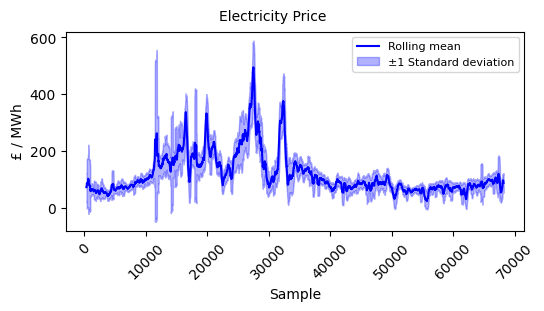

In [3]:
el_price = df_price.reset_index()["ELECTRICITY_PRICE"]
el_price_rolling_avg = el_price.rolling(48 * 7).mean().dropna()
el_price_rolling_std = el_price.rolling(48 * 7).std().dropna()

fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="constrained")

# Plot the mean
ax.plot(el_price_rolling_avg, label="Rolling mean", color='blue')

# Add shaded region for ±1 standard deviation
ax.fill_between(
    el_price_rolling_avg.index,
    el_price_rolling_avg - el_price_rolling_std,
    el_price_rolling_avg + el_price_rolling_std,
    alpha=0.3,
    color='blue',
    label='±1 Standard deviation'
)

ax.set_xlabel("Sample")
ax.set_ylabel("£ / MWh", fontsize=10)
ax.legend(fontsize=8)
fig.suptitle("Electricity Price", fontsize=10)
plt.xticks(rotation=45)
plt.show()

Plot half-hourly electricity prices over a shorter period:

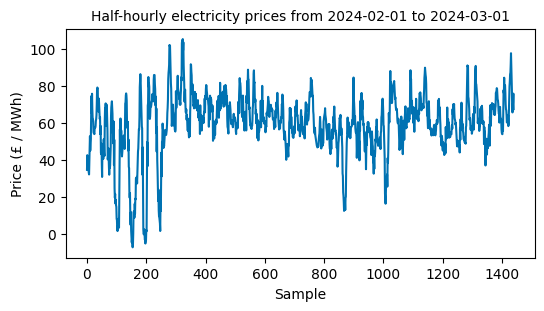

In [4]:
start_date = "2024-02-01"
end_date = "2024-03-01"

el_price = df_price["ELECTRICITY_PRICE"].loc[start_date:end_date]
el_price = el_price.reset_index()["ELECTRICITY_PRICE"]

fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="constrained")
ax.plot(el_price)
ax.set_title(
    f"Half-hourly electricity prices from {start_date} to {end_date}",
    fontsize=10,
)
ax.set_xlabel("Sample")
ax.set_ylabel("Price (£ / MWh)")
plt.show()

## 2. Price distribution

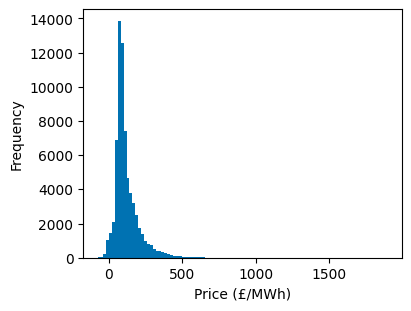

In [5]:
fig, ax = plt.subplots(figsize=(4, 3), layout="constrained")
ax.hist(df_price["ELECTRICITY_PRICE"], bins=100)
ax.set_xlabel("Price (£/MWh)", fontsize=10)
ax.set_ylabel("Frequency", fontsize=10)
plt.show()

Let's investigate monthly, weekly, daily and intraday price patterns:

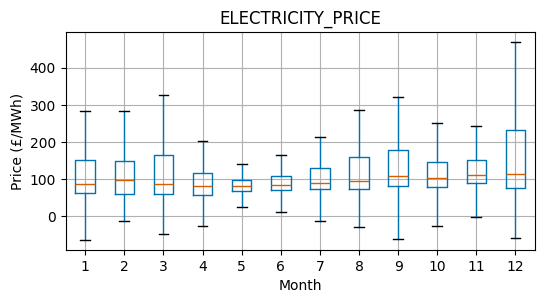

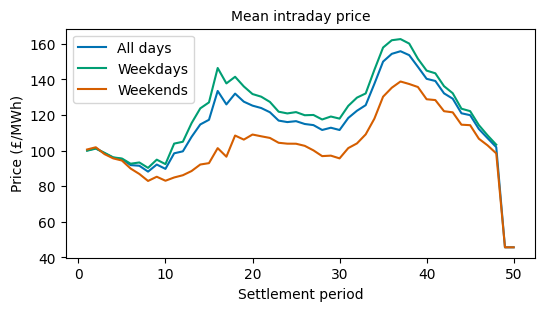

In [6]:
df = df_price.reset_index()

# Box plot by month (not showing outlier points)
df["MONTH"] = df["SETTLEMENT_DATE"].dt.month
fig, ax = plt.subplots(figsize=(16/3, 9/3), layout="constrained")
df.boxplot(column="ELECTRICITY_PRICE", by="MONTH", ax=ax, sym="")
ax.set_xlabel("Month", fontsize=10)
ax.set_ylabel("Price (£/MWh)", fontsize=10)
fig.suptitle("")
plt.show()

# Average price by settlement period (separating weekdays and weekends)
df["DAY_OF_WEEK"] = df["SETTLEMENT_DATE"].dt.dayofweek
df["IS_WEEKEND"] = df["DAY_OF_WEEK"] >= 5

fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="constrained")

intraday_mean = df.groupby(df["SETTLEMENT_PERIOD"])["ELECTRICITY_PRICE"].mean()
ax.plot(intraday_mean, label="All days")

for weekend, group in df.groupby("IS_WEEKEND"):
    p = group.groupby(group["SETTLEMENT_PERIOD"])["ELECTRICITY_PRICE"].mean()
    label = "Weekends" if weekend else "Weekdays"
    ax.plot(p, label=label)

ax.set_xlabel("Settlement period", fontsize=10)
ax.set_ylabel("Price (£/MWh)", fontsize=10)
ax.set_title("Mean intraday price", fontsize=10)
ax.legend()
plt.show()

*Comments:*
 
There are generally two peaks and two troughs in price per day. Each settlement period is 30 minutes, so the peaks are typically during the late morning hours and evening, while troughs are typically during the early morning hours and early afternoon. Weekends are cheaper than weekdays and have a much smaller morning peak than the weekdays.

## 3. Autocorrelation and stationarity

Plot autocorrelation function (ACF) and partial autocorrelation function (PACF):

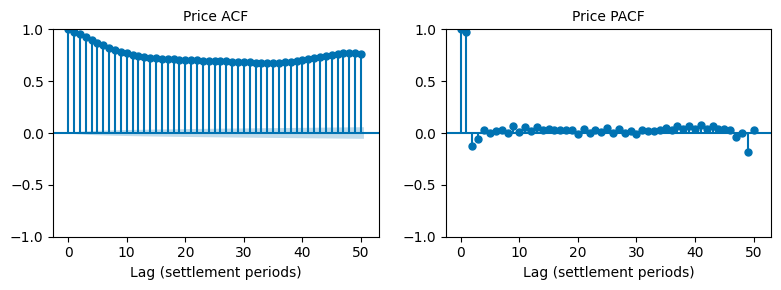

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

el_price = df_price["ELECTRICITY_PRICE"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16 / 2, 9 / 3), layout="tight")
plot_acf(el_price, lags=50, ax=ax1)
ax1.set_title("Price ACF", fontsize=10)
ax1.set_xlabel("Lag (settlement periods)", fontsize=10)
plot_pacf(el_price, lags=50, ax=ax2)
ax2.set_title("Price PACF", fontsize=10)
ax2.set_xlabel("Lag (settlement periods)", fontsize=10)
plt.show()

The data is clearly not stationary. Let's try to transform it to make it
stationary:

In [8]:
# Take a smaller snapshot to make plots more interpretable
start_date = "2023-01-01"
end_date = "2024-12-01"

df = df_price["ELECTRICITY_PRICE"].loc[start_date:end_date]
price = df.reset_index()["ELECTRICITY_PRICE"]

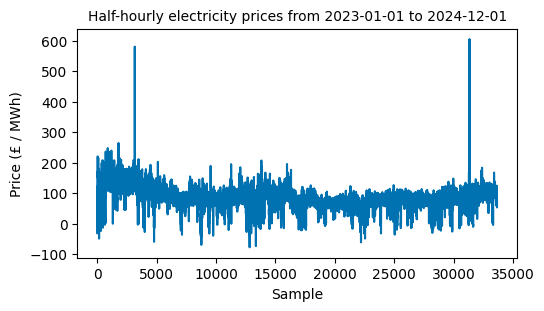

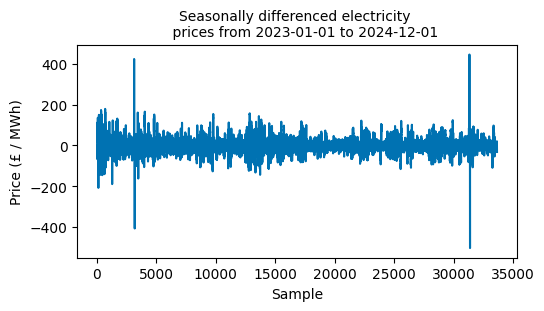

In [9]:
# Check whether or not we need to seasonal difference
fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="constrained")
ax.plot(price)
ax.set_title(
    f"Half-hourly electricity prices from {start_date} to {end_date}",
    fontsize=10,
)
ax.set_xlabel("Sample")
ax.set_ylabel("Price (£ / MWh)")
plt.show()

fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="constrained")
ax.plot(price.diff(48))
ax.set_title(
    f"""Seasonally differenced electricity 
    prices from {start_date} to {end_date}""",
    fontsize=10,
)
ax.set_xlabel("Sample")
ax.set_ylabel("Price (£ / MWh)")
plt.show()

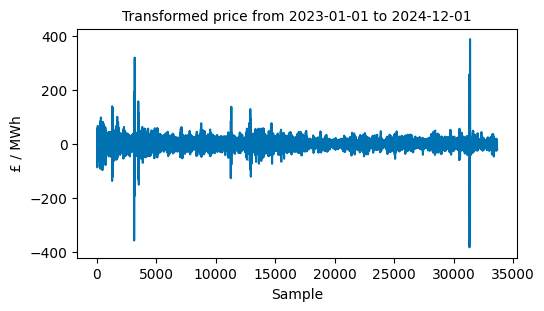

In [ ]:
# Transformed variable
x_trf = price.diff(48).diff(1)

fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="constrained")
ax.plot(x_trf)
ax.set_title(
    f"""Transformed price from {start_date} to {end_date}""",
    fontsize=10,
)
ax.set_xlabel("Sample")
ax.set_ylabel("£ / MWh")
plt.show()

x_trf_rolling_mean = x_trf.rolling(48).mean().dropna()
x_trf_rolling_std = x_trf.rolling(48).std().dropna()

fig, ax = plt.subplots(figsize=(16 / 3, 9 / 3), layout="constrained")

# Plot the mean
ax.plot(x_trf_rolling_mean, label="Rolling mean", color='blue')

# Add shaded region for ±1 standard deviation
ax.fill_between(
    x_trf_rolling_mean.index,
    x_trf_rolling_mean - x_trf_rolling_std,
    x_trf_rolling_mean + x_trf_rolling_std,
    alpha=0.3,
    color='blue',
    label='±1 Standard deviation'
)

ax.set_xlabel("Sample")
ax.set_ylabel("£ / MWh", fontsize=10)
ax.legend(fontsize=8)
fig.suptitle("Transformed variable", fontsize=10)
plt.xticks(rotation=45)
plt.show()

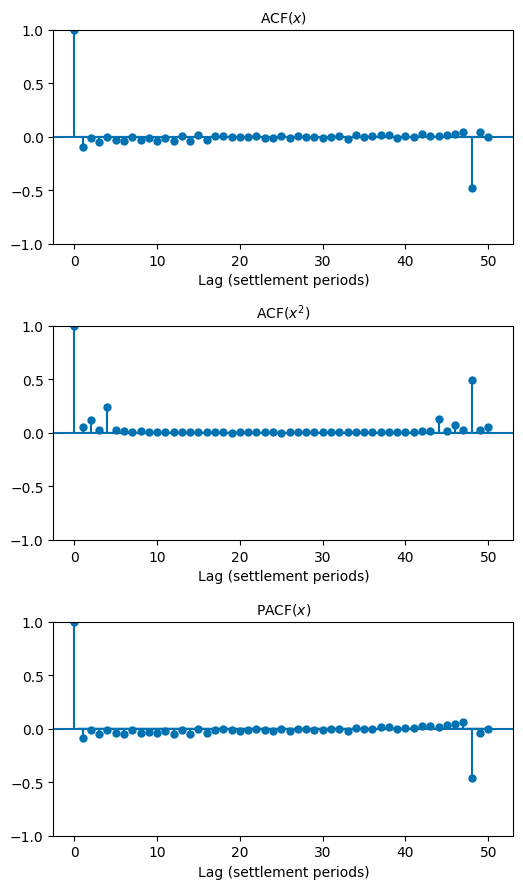

In [11]:
# Plot ACF and PACF of transformed variable
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16 / 3, 9), layout="tight")

# ACF
plot_acf(x_trf.dropna(), lags=50, ax=ax1)
ax1.set_title("ACF($x$)", fontsize=10)
ax1.set_xlabel("Lag (settlement periods)", fontsize=10)

# ACF of square variabled
plot_acf(x_trf.dropna()**2, lags=50, ax=ax2)
ax2.set_title("ACF($x^2$)", fontsize=10)
ax2.set_xlabel("Lag (settlement periods)", fontsize=10)

# PACF
plot_pacf(x_trf.dropna(), lags=50, ax=ax3)
ax3.set_title("PACF($x$)", fontsize=10)
ax3.set_xlabel("Lag (settlement periods)", fontsize=10)

plt.show()